In [1]:
import os

if "jbook" in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../..")))
import warnings

warnings.filterwarnings("ignore")
FORCE = True

# AppVoCAI Dataset Unboxing and Quality Assessment
In this section, we unbox and survey the dataset, profiling its structure, format, and substance to:

- illuminate data quality and integrity concerns requiring treatment prior to the analysis and modeling stawges, and
- reveal opportunities to improve exploratory analysis efforts with data enrichment

Exposing data quality and enrichment issues before our exploratory efforts ensures focus on the right questions, and discoveries that evince deep and nuanced insights into mobile app consumer behavior, and its implications for strategic opportunity discovery, selection and new product design

In [2]:
import logging
import matplotlib.pyplot as plt

from discover.assets.review import Review
from discover.assets.idgen import AssetIDGen
from discover.container import DiscoverContainer
from discover.infra.config.flow import FlowConfigReader
from explorify.eda.visualize.visualizer import Visualizer
from discover.core.flow import DataPrepStageDef, PhaseDef
from discover.flow.data_prep.ingest.stage import IngestStage
from discover.infra.utils.visual.print import Printer

In [3]:
container = DiscoverContainer()
container.init_resources()
container.wire(
    modules=[
        "discover.flow.data_prep.stage",
        "discover.app.base",
    ],
)

## Ingest Data
Register the raw dataset in the repository as an asset, enforcing data integrity and immutability principles such as write-once-read many (WORM).

In [4]:
# Obtain the configuration
reader = FlowConfigReader()
stage_config = reader.get_stage_config(
    phase=PhaseDef.DATAPREP, stage=DataPrepStageDef.INGEST
)

# Build and run Data Ingestion Stage
stage = IngestStage.build(stage_config=stage_config, force=FORCE)
asset_id = stage.run()



# ============================================================================== #
#                              Data Ingestion Stage                              #
# ============================================================================== #



                                   FilterTask                                   
                                   ----------                                   
                          Start Datetime | Wed, 06 Nov 2024 11:27:23
                       Complete Datetime | Wed, 06 Nov 2024 11:27:46
                                 Runtime | 23.61 seconds


                              Data Ingestion Stage                              
                           Stage Started | Wed, 06 Nov 2024 11:26:40
                         Stage Completed | Wed, 06 Nov 2024 11:28:01
                           Stage Runtime | 1.0 minutes and 21.68 seconds


# ============================================================================ #



## Load Data
Load the data from the repository in to a Review object.

In [5]:
# Instantiate the repository
repo = container.repo.dataset_repo()
# Load the dataset from the repository
df = repo.get(asset_id=asset_id).content
# Instantiate the Review object
reviews = Review(df=df)

In [6]:
reviews.overview()



                           AppVoCAI Dataset Overview                            
                       Number of Reviews | 221,666
                       Number of Authors | 220,325
                          Number of Apps | 13,943
                    Number of Categories | 14
                                Features | 11
                    Date of First Review | 2008-07-13 21:56:27
                     Date of Last Review | 2023-09-02 23:36:42


As evidenced here and stated earlier, The AppVoCAI captures over 22 million reviews from nearly 16 million users. These reviews span some 36,377 apps across 14 categories. The dataset contains 11 features and spans from July 10, 2008, the date the appstore launched, through early September of 2023.

## Structural Analysis
Before examining the content of the dataset, let's inspect its format and structure. 

In [7]:
reviews.info()

,Column,DataType,Complete,Null,Completeness,Unique,Duplicate,Uniqueness,Size (Bytes)
0,id,string[python],221666,0,1.0,221666,0,1.000000,14809692
1,app_id,string[python],221666,0,1.0,13943,207723,0.062901,14687317
2,app_name,string[python],221666,0,1.0,13937,207729,0.062874,18717680
3,category_id,object,221666,0,1.0,14,221652,0.000063,13521626
4,category,category,221666,0,1.0,14,221652,0.000063,223165
5,author,object,221666,0,1.0,220325,1341,0.993950,17068282
6,rating,float64,221666,0,1.0,5,221661,0.000023,1773328
7,content,string[python],221666,0,1.0,203142,18524,0.916433,81152635
8,vote_sum,Int64,221666,0,1.0,73,221593,0.000329,1994994
9,vote_count,Int64,221666,0,1.0,86,221580,0.000388,1994994


Several impressions:

1. **ID and Uniqueness**: The `id` column is showing some duplication (117 items) which will require treatment during the data cleaning stage.

2. **App-Specific Details (`app_id`, `app_name`)**: The cardinality of `app_id` exceeds that of `app_name` by 14, which indicates that some apps may have multiple ids, perhaps to uniquely identify different versions of the same app.

3. **Category Distribution**:  `category_id` and `category` are consistent, each with only 14 unique categories, suggesting clear category classifications across apps. 

4. **Authors and Reviews**: Duplication stats for the `author` column indicate that approximately 29% of the authors have submitted multiple reviews; yet, the vast majority of authors in the dataset have minimal engagement. 

5. **Rating Consistency**: The `rating` column has only 5 unique values, presumably in [1,5], to be confirmed below.

6. **Vote Metrics (`vote_count`, `vote_sum`)**: Both `vote_count` and `vote_sum` have low uniqueness (0.075% and 0.057%), suggesting that vote distributions are limited in range, possibly clustering around common values.

7. **Review Content**: Review content occupies approximately 8 Gb of memory, with a duplication rate approaching 14% (3,086,628 reviews). Duplication in text-based user generated content often indicates common patterns such as emojis and sentiment expressions throughout the dataset.

8. **Date**: Review `date` is appropriately typed as a datetime64 objects, representing an offset from 1970-01-001T00:00:00. Values range from 2008-07-10 10:15:37 to 2023-09-03 02:14:35.

9. **Data Completeness**: All columns are 100% complete, with no missing values, ensuring the dataset’s integrity for analysis.

10. **Data Format:** Most of the variables are appropriately typed. Casting `category_id` to category, and converting *object* types to *string* types will improve IO, storage efficiency and memory utilization.  

11. **Data Volume and Memory Considerations**: The dataset weighs in at about 4.9 Gb of memory, which may require special consideration during data preprocessing, analysis, and modeling stages. For instance, certain aggregations and computationally expensive analytics can be precomputed and re-used during the analysis stages, avoiding expensive calculations and supporting real-time analytics, and decreased iteration cycle times. 



### App Store Categories
The dataset spans 14 categories. Let's examine their distribution in terms of counts and proportions.

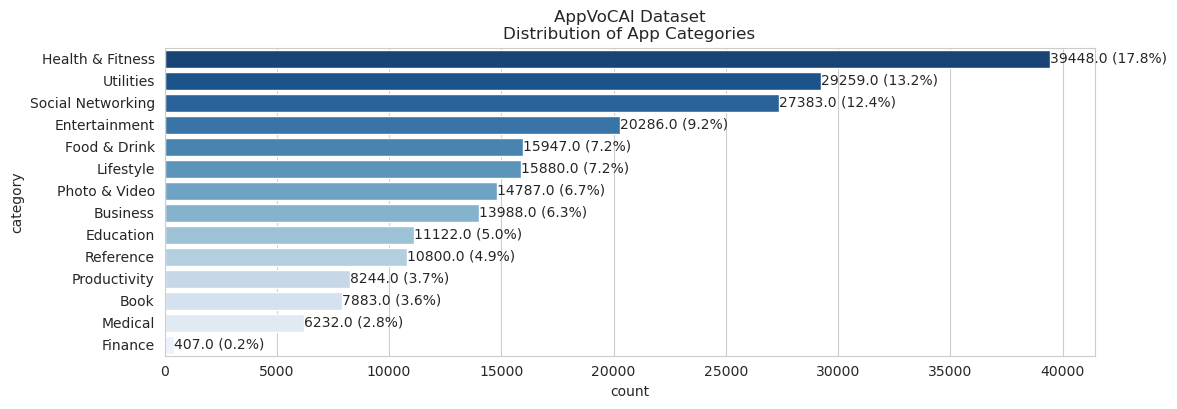

In [8]:
viz = Visualizer()
ax = viz.countplot(
    data=df,
    y="category",
    title="AppVoCAI Dataset\nDistribution of App Categories",
    order_by_count=True,
    plot_counts=True,
)

The distribution of reviews by app category in the AppVoCAI dataset provides insight into how review data is represented within this particular dataset, rather than reflecting any actual usage or popularity patterns in the app store at large.

1. **Higher Representation in Health & Fitness, Utilities, and Social Networking**: Categories such as Health & Fitness (17.8%), Utilities (13.2%), and Social Networking (12.3%) have the largest share of reviews in this dataset. This may reflect the way data was randomly sampled, rather than indicating a larger user base or greater engagement in these categories across the app store.

2. **Diverse Representation Across Lifestyle, Entertainment, and Food & Drink**: Categories like Lifestyle, Entertainment, and Food & Drink are also well represented in this dataset, accounting for a moderate portion of the reviews. Again, this distribution may simply result from the dataset's random sampling approach, rather than indicating broader trends.

3. **Lower Review Counts in Finance and Medical**: Some categories, such as Finance (0.2%) and Medical (2.8%), show fewer reviews in this dataset. This does not imply these categories are less popular or less reviewed in the app store but simply reflects the structure of this specific dataset.

4. **Focus on Dataset-Specific Insights**: While this distribution does not represent actual app store trends, it does provide an opportunity to examine patterns and themes within each category as represented in this dataset. For example, the high representation of certain categories might allow for a richer analysis of user sentiment or feature requests in those domains.

Again, this distribution should be viewed as unique to the AppVoCAI dataset, shaped by the random and stochastic nature of the acquisition process rather than as a representation of category popularity or review volume in the broader app store context.

## App Rating Validity
Ratings should be in [1,5].

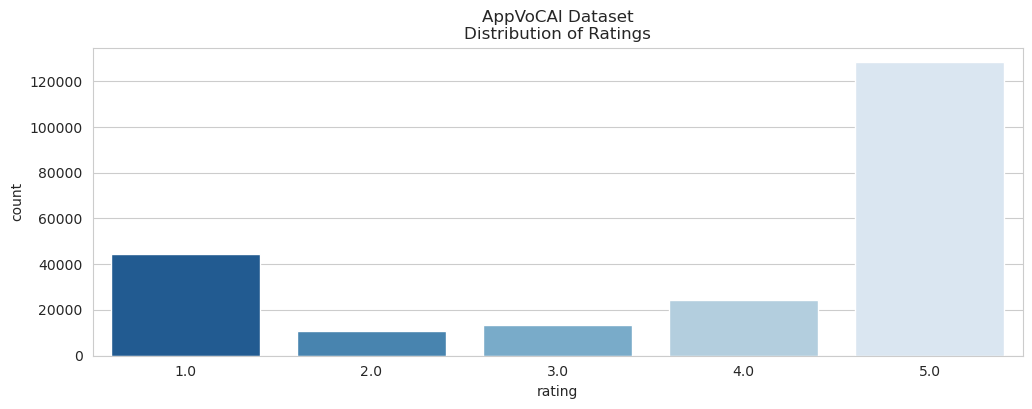

In [9]:
mlogger = logging.getLogger("matplotlib")
mlogger.setLevel(logging.ERROR)
ax = viz.countplot(
    data=df,
    x="rating",
    title="AppVoCAI Dataset\nDistribution of Ratings",
    order_by_count=False,
    plot_counts=False,
)

The chart confirms that the rating scale is indeed valid and consistent within the typical 1 to 5 range, with a notable concentration at the extremes - typical for app reviews, where users often rate very low or very high, with fewer moderate ratings in between.

## Vote Count and Vote Sum Validity
The `vote_count` and `vote_sum` values should be non-negative. Let's examine the distribution to validate and assess the presence of outliers.

In [10]:
df[["vote_count", "vote_sum"]].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T

,count,mean,std,min,5%,25%,50%,75%,95%,max
vote_count,221666.0,0.129357,2.729347,0.0,0.0,0.0,0.0,0.0,1.0,639.0
vote_sum,221666.0,0.086996,1.996646,0.0,0.0,0.0,0.0,0.0,0.0,631.0


The summary statistics for `vote_count` and `vote_sum` confirm that both variables are in the expected non-negative range, with minimum values of 0 and no negative entries. This validates that votes are recorded accurately as non-negative counts.

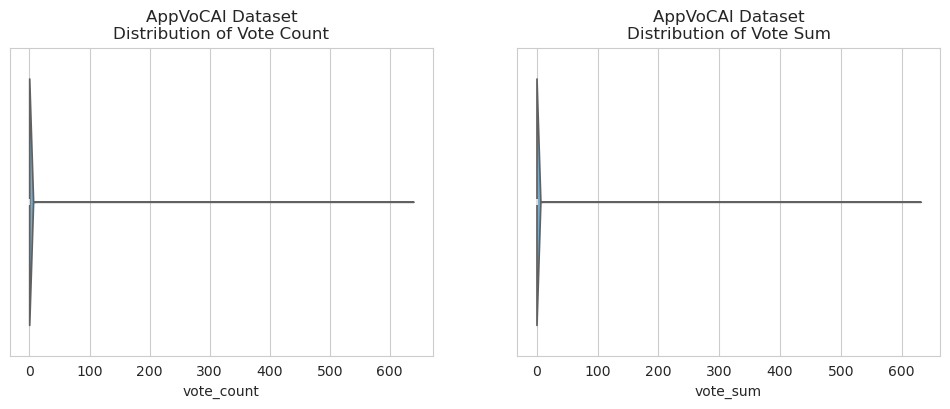

In [11]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=2, nrows=1)
ax = viz.violinplot(
    data=df,
    x="vote_count",
    title="AppVoCAI Dataset\nDistribution of Vote Count",
    ax=axes[0],
)
ax = viz.violinplot(
    data=df,
    x="vote_sum",
    title="AppVoCAI Dataset\nDistribution of Vote Sum",
    ax=axes[1],
)

However, the descriptive statistics and the plots indicate notable outliers in both distributions:

- **Vote Count**: While the majority of values are 0 (as indicated by the 25th, 50th, and 75th percentiles all being 0), the maximum `vote_count` reaches 8,494. This is significantly higher than the mean of 0.141 and suggests a small number of reviews with disproportionately high vote counts. These extreme values could represent highly influential reviews or may warrant further investigation to ensure they are legitimate.

- **Vote Sum**: Similarly, `vote_sum` has a maximum value of 4,433, which is much larger than the mean of 0.093. This also indicates outliers, possibly representing reviews with unusually high aggregate votes.

In both cases, these outliers may need to be considered carefully in any analysis, as they could skew averages or affect trend detection. Given the goals of the analysis, it might be useful to either cap or separately analyze these high values to better understand their impact.

## AppVoCAI Dataset Sample Observations 
To gain an initial, qualitative sense of the AppVoCAI dataset, let's take an early peek at a few randomly selected observations from the dataset. 

In [12]:
samples = df.sample(n=5, random_state=2)
samples

,id,app_id,app_name,category_id,author,rating,content,vote_sum,vote_count,date,category
188157,10267725886,1452906710,Wizz - Expand Your World,6005,4b840f7f4bb9a7cf1248,1.0,Met some nice decent guys and it’s a secretive...,0,0,2023-08-17 08:34:09,Social Networking
46066,6308142451,1508186374,Peacock TV: Stream TV & Movies,6016,5d23d781d4e3127ba017,1.0,I have tried mirror through my iPhone...all I...,0,0,2020-08-11 23:10:28,Entertainment
130745,9815139983,748920931,MyQuest for Patients,6020,f353ad4078854ecca0fb,5.0,I have had the Quest APP for years and I appre...,0,0,2023-04-12 20:59:09,Medical
27527,918017441,570060128,Duolingo - Language Lessons,6017,b88ff14f303210e2fdfd,5.0,I love this app. It has really helped me w/ my...,0,0,2014-01-01 04:40:35,Education
132703,980268469,597851882,Photo Editor,6008,0d34747042f4078b3a36,5.0,Best filters in a photo app,0,0,2014-04-20 18:56:21,Photo & Video


The sample includes a mix of highly rated apps, as well as lower ratings, all of which reflect different user experiences. The reviews span a significant time range, from as early as 2014 to as recent as 2023, showcasing both historical and recent user sentiments. However, a common feature across the sample is the absence of votes (both vote count and vote sum are zero). The EDA will illuminate the degree to which low engagement interaction is endemic or an aspect of our sample.

### Starbucks

In [13]:
printer = Printer()
printer.print_dataframe_as_dict(
    df=samples, list_index=0, title=samples["app_name"].values[0], text_col="content"
)



                            Wizz - Expand Your World                            
                                      id | 10267725886
                                  app_id | 1452906710
                                app_name | Wizz - Expand Your World
                             category_id | 6005
                                  author | 4b840f7f4bb9a7cf1248
                                  rating | 1.0
                                vote_sum | 0
                              vote_count | 0
                                    date | 2023-08-17 08:34:09
                                category | Social Networking
Met some nice decent guys and it’s a secretive app so that’s cool.


This review provides an insightful example of user feedback with both positive and negative elements. Here’s a breakdown of its content and potential implications for further analysis:

1. **Positive Acknowledgment of Design**: The user begins by appreciating the "new look" of the Starbucks app, indicating that recent visual or interface updates have been well-received. Positive mentions like this can highlight which design or functionality aspects resonate with users, useful information for product teams.

2. **Error in Notification System**: The main issue raised by the user is with the app's notification system. They report receiving incorrect notifications about their card balance, despite no actual change. This points to a potential bug or glitch where users are receiving notifications meant for other accounts, which could be a serious privacy or security concern. This is valuable feedback for the development and quality assurance teams.

3. **Trust and Reliability Concerns**: The user’s experience highlights a significant trust issue. Even though they verified their balance was correct upon checking, the fact that incorrect notifications were sent could undermine their confidence in the app. Users rely on financial apps to handle sensitive information accurately, and errors like these could harm the app’s reputation if widespread.

4. **Category Context**: This review falls under the "Food & Drink" category, where reliability, especially regarding financial transactions, is critical. Errors in financial notifications are likely to be a high-priority issue for this category, where users frequently manage balances and payments.

5. **Rating**: With a low rating of 2.0, this review contributes to a negative sentiment toward the app. This rating, combined with the detailed description of the issue, suggests that this bug significantly impacted the user’s experience.

**Implications for Analysis**: This review underscores the importance of checking for themes around notification accuracy and user trust, especially in categories that involve financial transactions. In an Aspect-Based Sentiment Analysis (ABSA) process, aspects like “design” (positive) and “notifications” or “balance accuracy” (negative) could be identified. This review also highlights how user trust can be impacted by seemingly minor but persistent bugs, making it an important consideration for opportunity discovery in this app's improvement.

### T-Mobile

In [14]:
printer.print_dataframe_as_dict(
    df=samples, list_index=1, title=samples["app_name"].values[1], text_col="content"
)



                         Peacock TV: Stream TV & Movies                         
                                      id | 6308142451
                                  app_id | 1508186374
                                app_name | Peacock TV: Stream TV & Movies
                             category_id | 6016
                                  author | 5d23d781d4e3127ba017
                                  rating | 1.0
                                vote_sum | 0
                              vote_count | 0
                                    date | 2020-08-11 23:10:28
                                category | Entertainment
I have tried  mirror through my iPhone...all I get on my tv is the audio, no
video😔


This review provides strong negative feedback, focusing on customer service and account management issues. Here’s an analysis of its key elements:

1. **Frustration with Customer Service**: The reviewer expresses intense dissatisfaction with T-Mobile’s customer service, specifically citing “incompetence” and a lack of training among staff. This indicates that, from the user’s perspective, T-Mobile employees lack the necessary knowledge or skills to handle customer accounts effectively. Such feedback points to a perceived gap in customer service quality, which could have implications for both training programs and customer service policies.

2. **Urgency and Emotional Intensity**: Words like “absolutely horrific” and the use of all caps in “IMMEDIATELY” emphasize the user’s frustration and sense of urgency. This heightened emotional tone suggests that the experience may have significantly affected the user’s perception of T-Mobile, potentially leading to a loss of loyalty or trust. High-intensity language like this could be flagged in sentiment analysis as a strong indicator of negative sentiment.

3. **Rating**: The review is rated 1.0, the lowest possible score, which aligns with the severe dissatisfaction expressed in the text. This low rating adds weight to the feedback, highlighting the negative impact of the experience on the user’s overall view of the company.

4. **Lack of Specific Details**: Although the review conveys intense dissatisfaction, it lacks specific examples of what went wrong. This lack of detail can make it challenging for the company to pinpoint and address the exact issues. However, the general sentiment still provides valuable insight into potential areas of improvement in training and customer service protocols.

5. **Category Context**: As a “Utilities” app, T-Mobile’s app likely serves a functional purpose, providing access to account management and customer service. Poor customer service experiences are especially damaging in utility apps, as users expect efficient and reliable support when managing essential services like mobile accounts.

**Implications for Analysis**: This review highlights the importance of customer service competence and the need for effective employee training in handling accounts. In an Aspect-Based Sentiment Analysis (ABSA), aspects like “customer service” and “employee knowledge” could be flagged with strong negative sentiment. The urgency and intensity of the language also suggest that T-Mobile may need to prioritize improvements in its customer service quality to prevent similar negative experiences. This review serves as a reminder that even without specific details, user feedback can signal underlying systemic issues in customer support and account management that may require attention.

### Human Anatomy Atlas 2023

In [15]:
printer.print_dataframe_as_dict(
    df=samples, list_index=2, title=samples["app_name"].values[2], text_col="content"
)



                              MyQuest for Patients                              
                                      id | 9815139983
                                  app_id | 748920931
                                app_name | MyQuest for Patients
                             category_id | 6020
                                  author | f353ad4078854ecca0fb
                                  rating | 5.0
                                vote_sum | 0
                              vote_count | 0
                                    date | 2023-04-12 20:59:09
                                category | Medical
I have had the Quest APP for years and I appreciate it very much! As an insulin
dependent diabetic, I have blood work done every 3 months. Quest is dependable,
accurate and provide an excellent service.


This review provides positive feedback, focusing on the app’s functionality and customer support effectiveness. Here’s an analysis of its key elements:

1. **Satisfaction with the App**: The reviewer expresses strong satisfaction with the **Human Anatomy Atlas 2023** app, appreciating its functionality and usefulness. This endorsement suggests that the app meets or exceeds the user’s expectations for an educational tool in the Medical category, providing value to users looking to explore anatomical information.

2. **Effective Customer Support**: The user reports a positive experience with customer support after encountering an issue with the app loading following an iOS update. They mention reaching out, providing proof of purchase, and having the issue resolved. This feedback highlights the responsiveness and helpfulness of the customer support team, which is a significant factor in user satisfaction, particularly when technical issues arise due to system updates.

3. **Rating**: The review is rated 5.0, the highest possible score, aligning with the user’s positive experience. This high rating reinforces the value the user places on both the app’s functionality and the quality of customer support.

4. **Issue Resolution**: Although the user experienced a loading issue, their positive response suggests that prompt and effective customer support can mitigate frustration and even enhance user satisfaction. This review indicates that addressing issues quickly and respectfully can turn potentially negative experiences into positive ones.

5. **Category Context**: As a Medical app, **Human Anatomy Atlas 2023** is likely expected to provide reliable, educational resources, where users rely on the app for study or professional reference. Effective customer support is especially important in this context, as users depend on the app’s consistent functionality.

**Implications for Analysis**: This review underscores the importance of customer support in maintaining high user satisfaction, even when technical issues occur. In an Aspect-Based Sentiment Analysis (ABSA), aspects like “customer support” and “app reliability” could be flagged with positive sentiment. This review demonstrates that customer support is crucial in Medical apps, where users depend on the app’s reliability and responsiveness to issues.

### BetterSleep: Relax and Sleep                          


In [16]:
printer.print_dataframe_as_dict(
    df=samples, list_index=3, title=samples["app_name"].values[3], text_col="content"
)



                          Duolingo - Language Lessons                           
                                      id | 918017441
                                  app_id | 570060128
                                app_name | Duolingo - Language Lessons
                             category_id | 6017
                                  author | b88ff14f303210e2fdfd
                                  rating | 5.0
                                vote_sum | 0
                              vote_count | 0
                                    date | 2014-01-01 04:40:35
                                category | Education
I love this app. It has really helped me w/ my Spanish skills!!!


This review provides positive feedback, focusing on the app’s effectiveness in helping the user improve their sleep. Here’s an analysis of its key elements:

1. **Satisfaction with App Functionality**: The reviewer expresses strong satisfaction with **BetterSleep: Relax and Sleep**, emphasizing that the app has positively impacted their sleep quality. This indicates that the app meets its intended purpose, providing effective tools or content for relaxation and sleep improvement.

2. **Emotion and Tone**: The tone of the review is enthusiastic and appreciative, with the user conveying genuine happiness with the app’s impact. Phrases like "Love it!" reinforce this positive sentiment, suggesting that the app has made a noticeable difference in the user’s daily life.

3. **Rating**: The review is rated 5.0, the highest possible score, which aligns with the positive feedback. This high rating reinforces the effectiveness of the app for this particular user, potentially indicating strong alignment between the app's purpose and user expectations.

4. **Brevity and Clarity**: Although the review is brief, it effectively communicates the user’s satisfaction and the app’s perceived value. The concise feedback serves as a quick but clear endorsement of the app’s effectiveness in promoting better sleep.

5. **Category Context**: As a Health & Fitness app, **BetterSleep: Relax and Sleep** is expected to support users’ well-being, in this case by aiding sleep quality. Positive reviews in this category are particularly valuable, as they may help build trust among potential users seeking solutions for sleep-related issues.

**Implications for Analysis**: This review highlights the app’s success in delivering on its promise to improve sleep, an important aspect for Health & Fitness apps targeting well-being and relaxation. In an Aspect-Based Sentiment Analysis (ABSA), aspects like “effectiveness” and “sleep improvement” could be flagged with positive sentiment. This review suggests that **BetterSleep** is well-received by users looking for accessible and effective sleep aids.

### MyFitnessPal: Calorie Counter App Review

In [17]:
printer.print_dataframe_as_dict(
    df=samples, list_index=4, title=samples["app_name"].values[4], text_col="content"
)



                                  Photo Editor                                  
                                      id | 980268469
                                  app_id | 597851882
                                app_name | Photo Editor
                             category_id | 6008
                                  author | 0d34747042f4078b3a36
                                  rating | 5.0
                                vote_sum | 0
                              vote_count | 0
                                    date | 2014-04-20 18:56:21
                                category | Photo & Video
Best filters in a photo app


This review provides positive feedback, focusing primarily on the quality of customer support rather than the app itself. Here’s an analysis of its key elements:

1. **Praise for Customer Support**: The reviewer specifically commends a customer support representative named Quinshay for their detailed and responsive approach to addressing user concerns. This suggests that Quinshay’s assistance left a strong, positive impression, showcasing ABC’s commitment to user satisfaction and problem-solving.

2. **Unique Motivation for Rating**: Although the reviewer hasn’t fully used the app yet, they still awarded it a 5-star rating based on their experience with customer support. This unique motivation highlights the importance of attentive and proactive support, which can positively impact perceptions even before users engage with the app’s core features.

3. **Emotion and Tone**: The review is enthusiastic and appreciative, conveying a sense of trust and admiration for the ABC app team’s commitment to addressing user feedback. The use of phrases like “KUDOS TO YOU, ABC!!” and emoji (e.g., thumbs up, sunglasses) further emphasizes the user’s positive emotions and satisfaction.

4. **Rating**: The 5.0 rating reflects the reviewer’s appreciation for the customer support experience, which they see as indicative of a customer-centric approach. This high rating, despite limited app usage, underscores how exceptional support can strongly influence user perception.

5. **Category Context**: As an Entertainment app, **ABC: Stream TV Series & Sports** caters to users seeking on-demand content. While users might primarily engage with such an app for content streaming, this review highlights that customer support quality can be a pivotal factor in building brand loyalty and positive user sentiment, even in entertainment contexts.

**Implications for Analysis**: This review underscores the value of customer support as a key factor in user satisfaction and perception. In an Aspect-Based Sentiment Analysis (ABSA), aspects like “customer support responsiveness” and “user engagement” could be flagged with positive sentiment. This feedback demonstrates that timely, personalized responses can foster trust and loyalty, potentially encouraging other users to engage more with the app.

## Data Enrichment
Data enrichment transforms raw data into a more valuable asset for generating insights by adding attributes that provide additional context and depth. Once the dataset has been cleaned, we will introduce several new attributes designed to enhance the utility of our exploratory analysis:

1. **Sentiment Classification**: Using the spaCy SentimentAnalyzer, we’ll efficiently incorporate high-level sentiment analysis during the exploratory phase. More in-depth, computationally demanding, LLM-based aspect-based sentiment analysis will be deferred to subsequent modeling stages, ensuring resource efficiency.
2. **Review Age**: Calculated as the difference between the review date and the most recent review date in the dataset, this variable will illuminate trends over time, such as evolving user expectations or the impact of app updates.
3. **Review Length**: By measuring the number of words in each review, we can analyze how review detail correlates with sentiment, rating, and user engagement. Lengthier reviews often reflect stronger user opinions and can provide richer qualitative insights.
4. **App Rating Deviation**: This metric captures the difference between an individual review’s rating and both the app's average rating and the category average. Identifying significant deviations can spotlight unique user perspectives or areas of disagreement.
5. **Review Length Deviation**: This variable compares each review’s length to the average for the app and the category, uncovering engagement patterns and indicating whether specific apps or categories elicit more detailed feedback.
6. **Author Review Count**: Tracking the number of reviews submitted by each author allows us to differentiate between casual and frequent reviewers, shedding light on power users whose feedback might carry greater significance or reflect deeper engagement.

## Performance Considerations for EDA
Given the dataset’s size, computationally intensive analyses can lead to extended processing times, delayed feedback, and reduced agility. To facilitate efficient and iterative exploratory analysis, complex aggregations and summaries at the app, author, and category levels will be precomputed during data preparation. These aggregations will be materialized in Parquet files, chosen for their highly efficient data compression, minimized storage footprint, and faster data transfer.

It is crucial to emphasize that this enrichment process is distinct from data cleaning or feature engineering. While feature engineering focuses on creating predictive features to optimize *model* performance, data enrichment enhances the dataset's richness solely for exploration. This approach ensures the data remains unbiased for discovery, enriching the dataset for EDA without introducing transformations that might skew analysis.

## Summary and Key Takeaways
Our overview of the AppVoCAI dataset confirms a robust collection of 22.2 million reviews, submitted by approximately 15.7 million users across 36,377 apps. A comprehensive structural analysis assessed data types, row and dataset completeness, duplication, cardinality, and overall dataset size. We found the dataset to be fully complete, with no missing values and no duplicate rows. However, field-level duplication was identified in the review `id` variable, affecting 117 observations, and in the review `content` field, where approximately 14% of entries are duplicated. 

Descriptive statistics and visualizations validated key elements, including categories, ratings, vote counts, and review dates, ensuring data integrity and laying the foundation for further exploration. 

This concludes the unboxing and data quality assessment of the AppVoCAI dataset. Up next: data cleaning.